In [ ]:
import os, sys
from shutil import copyfile
from datetime import datetime
import importlib
import skimage

In [3]:
import fastai
from fastai.vision.all import *
from fastai.basics import *
from torch.utils.tensorboard import SummaryWriter
from fastai.callback.fp16 import ModelToHalf
from fastai.callback.hook import hook_output
import tensorboard

In [4]:
sys.path.append(".")

from tensorboard_helpers import TensorBoardBaseCallback, TensorBoardCallback

In [6]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")

In [7]:
path = Path(ml_data_path)

oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [8]:
import skimage.io as skio
import numpy as np

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
for i in labels.glob("*.png"):
    arr = skio.imread(i)
    values = np.unique(arr)
    arr[arr==3] = 0
    try:
        skio.imsave(labels_no_3 / i.name, arr, check_contrast=False)
    except:
        continue

In [9]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

473

In [10]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [11]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
lcl =  Path('/root/data/experiments/cv1/'+timestampStr+'/')
#lcl = Path("../out_data")
lcl.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [12]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

In [13]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [14]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda

In [15]:
seg_db.summary(path)

Setting-up type transforms pipelines
Found 473 items
2 datasets of sizes 369,104
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_lbls -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/data/cv1_transfer/labeled_data/chp/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: get_lbls -> PILBase.create
    starting from
      /root/data/cv1_transfer/labeled_data/chp/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying get_lbls gives
      /root/data/cv1_transfer/labeled_data/lbl_no3/S1A_IW_GRDH_1SDV_20200422T023108_20200422T023133_032234_03BA81_5FD7_0.png
    applying PILBase.create gives
      PILMask mode=L size=512x512

Final sample: (PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)


Found 473 items
2 datasets of sizes 369,104
Setting up Pipeline: PILBase.create
Setting up Pipeline

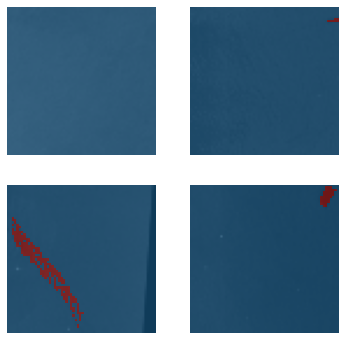

In [16]:
dls.show_batch(vmin=0, vmax=3)

In [17]:
# add best model callback saver
# write to drive not lcl

In [18]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [19]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

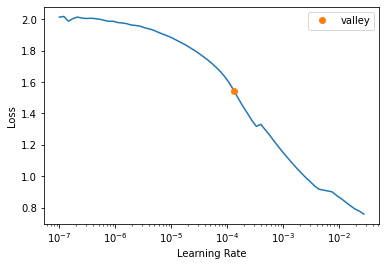

In [20]:
lr = learn.lr_find()

In [21]:
lr

SuggestedLRs(valley=0.00013182566908653826)

In [22]:
cbs = [TensorBoardCallback(projector=False, trace_model=False)]


In [23]:
learn.fine_tune(5, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

epoch,train_loss,valid_loss,dice,time
0,0.237727,0.051761,0.000000,00:17


epoch,train_loss,valid_loss,dice,time
0,0.034287,0.047194,0.000000,00:15
1,0.027976,0.029303,0.002637,00:15
2,0.023155,0.025119,0.156025,00:15
3,0.020819,0.024729,0.307095,00:17
4,0.018505,0.024251,0.294438,00:15


In [24]:
# learn.load("model")

In [25]:
learn

In [26]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(f'{modelpath}/{savename}')

In [27]:
ls {modelpath}

0_18_64_0.294.pkl


/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


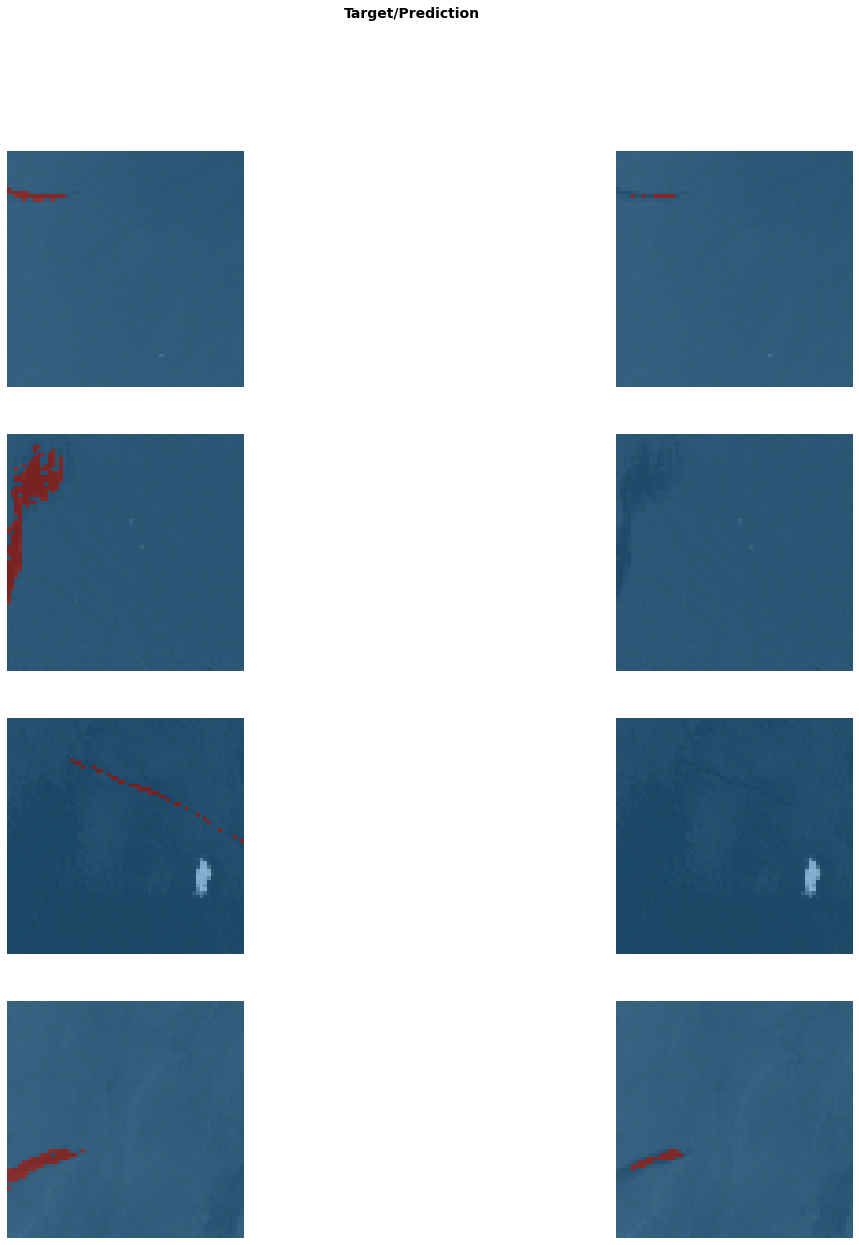

In [28]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [29]:
!ls './runs/'

Mar09_17-11-40_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_17-12-26_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_17-25-55_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_17-26-10_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_18-40-54_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_18-43-13_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_18-43-31_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_18-53-31_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_18-53-50_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_19-58-16_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4
Mar09_19-58-33_ml-jupyter-a4764b5d-8501-2ee7-0c4d-9a2c90c119a4


Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [30]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="gs://cerulean/experiments/cv1/09_Mar_2022_18_32_17/tensorboard"
